In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox  
from osmnx import geocoder
import matplotlib.animation as animation
import random
import time

/home/francesco/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/francesco/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
place = "Copenhagen Municipality, Denmark"

G = ox.graph_from_place(place,  network_type='walk') 
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)  
ox.save_graphml(G, 'graph.graphml')
nodes.to_csv('nodes.csv')
edges.to_csv('edges.csv')

print('Place data fetched and saved successfully')

Place data fetched and saved successfully


In [4]:
nodes = pd.read_csv('nodes.csv')
edges = pd.read_csv('edges.csv')
print(edges.head())
#fig, ax = ox.plot_graph(G)


        u           v  key       osmid   highway maxspeed              name  \
0  118725  2512504197    0  1355182986  tertiary       30  Banegårdspladsen   
1  118738  4924695592    0   699713642   service      NaN               NaN   
2  118744  1277939659    0   699713644   service      NaN               NaN   
3  118744  1277939659    1   112439593   service      NaN               NaN   
4  118744  1277939654    0   112439593   service      NaN               NaN   

   oneway reversed     length  \
0   False    False  14.315994   
1   False     True  11.838357   
2   False    False  15.868216   
3   False     True  99.070859   
4   False    False  64.339114   

                                            geometry        service bridge  \
0  LINESTRING (12.5629097 55.6739757, 12.5629715 ...            NaN    NaN   
1  LINESTRING (12.5618351 55.6628366, 12.5617904 ...            NaN    NaN   
2  LINESTRING (12.5600339 55.6617175, 12.5601929 ...  parking_aisle    NaN   
3  LINESTRING 

In [5]:
G = ox.load_graphml('graph.graphml')
print(G)

MultiDiGraph with 37113 nodes and 102980 edges


In [ ]:
def plot_path(G, path):

    route_x, route_y = zip(*[(G.nodes[node]["x"], G.nodes[node]["y"]) for node in path])


    padding = 0.001 
    x_min, x_max = min(route_x) - padding, max(route_x) + padding
    y_min, y_max = min(route_y) - padding, max(route_y) + padding

    fig, ax = plt.subplots(figsize=(8, 8))

    ox.plot_graph(G, ax=ax, show=False, close=False, bgcolor='white')
    ax.plot(route_x[0], route_y[0], color='yellow', linewidth=5, marker='o')
    ax.plot(route_x[-1], route_y[-1], color='yellow', linewidth=5, marker='*')
    ax.plot(route_x, route_y, color='red')
    ax.set_xlim(x_min, x_max) 
    ax.set_ylim(y_min, y_max)
    plt.show()

def plot_multi_path(G, paths):
    fig, ax = plt.subplots(figsize=(8, 8))
    ox.plot_graph(G, ax=ax, show=False, close=False, bgcolor='white')

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, path in enumerate(paths):
        route_x, route_y = zip(*[(G.nodes[node]["x"], G.nodes[node]["y"]) for node in path])
        
        color = colors[i % len(colors)]
        
        ax.plot(route_x, route_y, color=color, label=f'Path {i+1}')
    ax.plot(route_x[0], route_y[0], color='yellow', linewidth=5, marker='o')
    ax.plot(route_x[-1], route_y[-1], color='yellow', linewidth=5, marker='*')
    ax.legend()
    ax.set_xlim(min(route_x) - 0.001, max(route_x) + 0.001)
    ax.set_ylim(min(route_y) - 0.001, max(route_y) + 0.001)
    plt.show()

def find_neighbors(G, node_id):
    ''' 
    This function returns a list with the ids of the neighbors of a node.

    Arguments:
        - G: a graph object
        - node_id: the id of the node to find the neighbors of

    Returns:
        - neighbors: a list with the ids of the neighbors of the node

    '''
    neighbors = []
    for neighbor in G.neighbors(node_id):
        neighbors.append(neighbor)

    if len(neighbors) == 0:
        print('Node has no neighbors')
    return np.array(neighbors)


def real_dist_nodes( edges, node1_id, node2_id):
    '''  
    This function returns a the distance between two connected nodes.

    Arguments:
        - edges: edges data frame
        - node1_id: node 1 id
        - node2_id: node 2 id

    Returns:
        - length: length between the connected nodes
    
    '''
    edge = edges[(edges['u'] == node1_id) & (edges['v'] == node2_id)]
    if not edge.empty:
        return edge.iloc[0]['length']
    else:
        print('Nodes are not connected')
        return None 


def euc_dist_nodes(G, edges, node1_id, node2_id):
    y1, x1, y2, x2 = [] , [], [], []

    for i in range(len(node1_id)):
        node_data = G.nodes[node1_id[i]]
        y1.append(node_data['y'])
        x1.append(node_data['x'])
    for j in range(len(node2_id)):
        node_data = G.nodes[node2_id[j]]
        y2.append(node_data['y'])
        x2.append(node_data['x'])
    y1, x1, y2, x2 = np.array(y1), np.array(x1), np.array(y2), np.array(x2)
    return ox.distance.euclidean(y1, x1, y2, x2)        
    

def distance_to_prob(dist):
    ''' 
    This function returns the probability of a path given the distance.

    Arguments:
        - dist: distance of the path

    Returns:
        - prob: normalized probability of the path

    '''
    prob = 1/dist
    return prob / np.sum(prob)

def length_population(G, pop):
    fitness = []
    for i in range(len(pop)):
        fitness.append(sum(G[u][v][0]['length'] for u, v in zip(pop[i][:-1], pop[i][1:])))
    return fitness

def find_path(G, edges, nodes, start_id, end_id):
    current_id = start_id
    path = [current_id]

    while current_id != end_id:
        neigh = find_neighbors(G, current_id)
        if len(neigh) == 0:
            #print('No neighbours found, terminating search.')
            break
        dist_to_end = euc_dist_nodes(G, edges, neigh, [end_id])

        if np.any(dist_to_end==0):
            #print('Path found!')
            path.append(end_id)
            break

        prob = distance_to_prob(dist_to_end)

        current_id = np.random.choice(neigh, p=prob)

        path.append(current_id)

    return np.array(path)


def populate(G, edges, nodes, start_id, end_id, num_pop):
    population= []
    for n in range(num_pop):
        path = find_path(G, edges, nodes, start_id, end_id)
        population.append(path)
    return population

In [56]:
def best_survive(population , lengths, fraction) : 
    '''this function is getting a population and the lengths of the paths and returns the best fraction of the population'''
    sorted_indices = np.argsort(lengths)
    sorted_population = [population[i] for i in sorted_indices]
    survivors = int(fraction * len(population))

    survivors_pop = sorted_population[:survivors]
    return survivors_pop

def sex(parent1, parent2):
    common = list(set(parent1) & set(parent2))
    cnode = random.choice(common)

    idx1 = int(random.choice(np.where(parent1==cnode)[0]))
    idx2 = int(random.choice(np.where(parent2==cnode)[0]))

    if np.random.randint(0,2) == 0:
        child = np.concatenate((parent1[:idx1], parent2[idx2:]))
    else:
        child = np.concatenate((parent2[:idx2], parent1[idx1:]))
    return child

In [57]:
def evolution(nodestart, nodeend, generations, fraction, population_size, G= G, edges=edges, nodes=nodes ):
    '''This function is performing the genetic algorithm to find the best path between two nodes'''
    best_length = []
    survivors_pop = []
    population = populate(G, edges, nodes, nodestart, nodeend, population_size)
    lengths = length_population(G, population)
    survivors_pop = best_survive(population, lengths, fraction)
    best_length.append(min(lengths))
    for gen in range(generations):

        # Generate new population
        population = survivors_pop 
        while population_size > len(population):
            parent1, parent2 = random.sample(survivors_pop, 2)
            population.append(sex(parent1, parent2))
        
        #getting the best
        lengths = length_population(G, population)
        survivors_pop = best_survive(population, lengths, fraction)

        #saving stuff
        best_length.append(min(lengths))
        print('Generation', gen+1)
        print('Best length', best_length[-1])
        
    best_path = survivors_pop[0]
    plot_path(G, best_path)
    return best_path, best_length


Generation 1
Best length 4318.536152878228
Generation 2
Best length 4318.536152878228
Generation 3
Best length 4318.536152878228
Generation 4
Best length 4318.536152878228
Generation 5
Best length 3326.361349340489
Generation 6
Best length 3326.361349340489
Generation 7
Best length 3219.3271361089596
Generation 8
Best length 3219.3271361089596
Generation 9
Best length 3159.689444452179
Generation 10
Best length 3159.689444452179
Generation 11
Best length 3159.689444452179
Generation 12
Best length 3159.689444452179
Generation 13
Best length 3159.689444452179
Generation 14
Best length 3020.644529889884
Generation 15
Best length 3020.644529889884


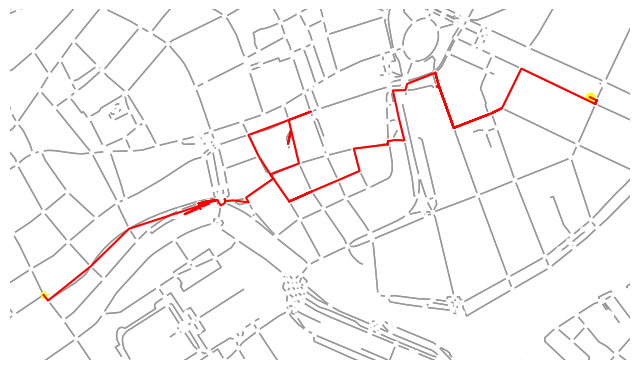

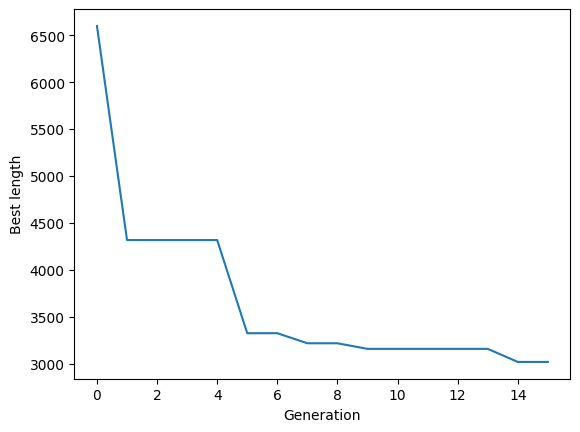

In [59]:
latstart, lonstart = ox.geocoder.geocode('Nyhavn, Copenhagen, Denmark')
nodestart = ox.distance.nearest_nodes(G, lonstart, latstart)
latend, lonend = ox.geocoder.geocode('Bastard Cafe, Copenhagen, Denmark')
nodeend = ox.distance.nearest_nodes(G, lonend, latend)

best_path, best_lengths = evolution(nodestart, nodeend, 15, 0.5, 10)
plt.plot(best_lengths)
plt.xlabel('Generation')
plt.ylabel('Best length')
plt.show()